In [2]:
import os
import random
import pathlib

from zipfile import ZipFile
import glob as glob
import requests

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass


In [3]:
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

- Download and extract files.

In [4]:
def download_file(url, save_path):
  print("Downloading and extracting files....", end="")

  url = url
  file = requests.get(url)

  open(save_path, 'wb').write(file.content)

def unzip(zip_file=None):
  try:
    with ZipFile(zip_file) as z:
      z.extractall(os.path.split(zip_file)[0])

      print("Done")
  except Exception as e:
    print("\nInvalid file", e)

In [5]:
URL = r"https://www.dropbox.com/s/uzgh5g2bnz40o13/dataset_traffic_signs_40_samples_per_class.zip?dl=1"
save_path = "dataset_traffic_signs_40_samples_per_class.zip"

download_file(URL, save_path)
unzip(zip_file="dataset_traffic_signs_40_samples_per_class.zip")

- Dataset and Training Configuration

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
  NUM_CLASSES:  int = 43
  IMG_WIDTH:    int = 224
  IMG_HEIGHT:   int = 224
  NUM_CHANNELS: int = 3

  DATA_ROOT_TRAIN: str = "./dataset_traffic_signs_40_samples_per_class/Train"
  DATA_ROOT_VALID: str = "./dataset_traffic_signs_40_samples_per_class/Valid"
  DATA_ROOT_TEST : str = "./dataset_traffic_signs_40_samples_per_class/Test"
  DATA_TEST_GT:    str = "./dataset_traffic_signs_40_samples_per_class/Test.csv"

@dataclass(frozen=True)
class TrainingConfig:
  BATCH_SIZE:       int   = 32
  EPOCHS:           int   = 101
  LEARNING_RATE:    float = 0.0001
  DROPOUT:          float = 0.6
  LAYERS_FINE_TUNE: int = 8

- Load image datasets.

In [7]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                              batch_size=TrainingConfig.BATCH_SIZE,
                                              shuffle=True,
                                              seed=SEED_VALUE,
                                              label_mode='int', #Integer encoding.
                                              image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                              )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT)
                                             )

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [8]:
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


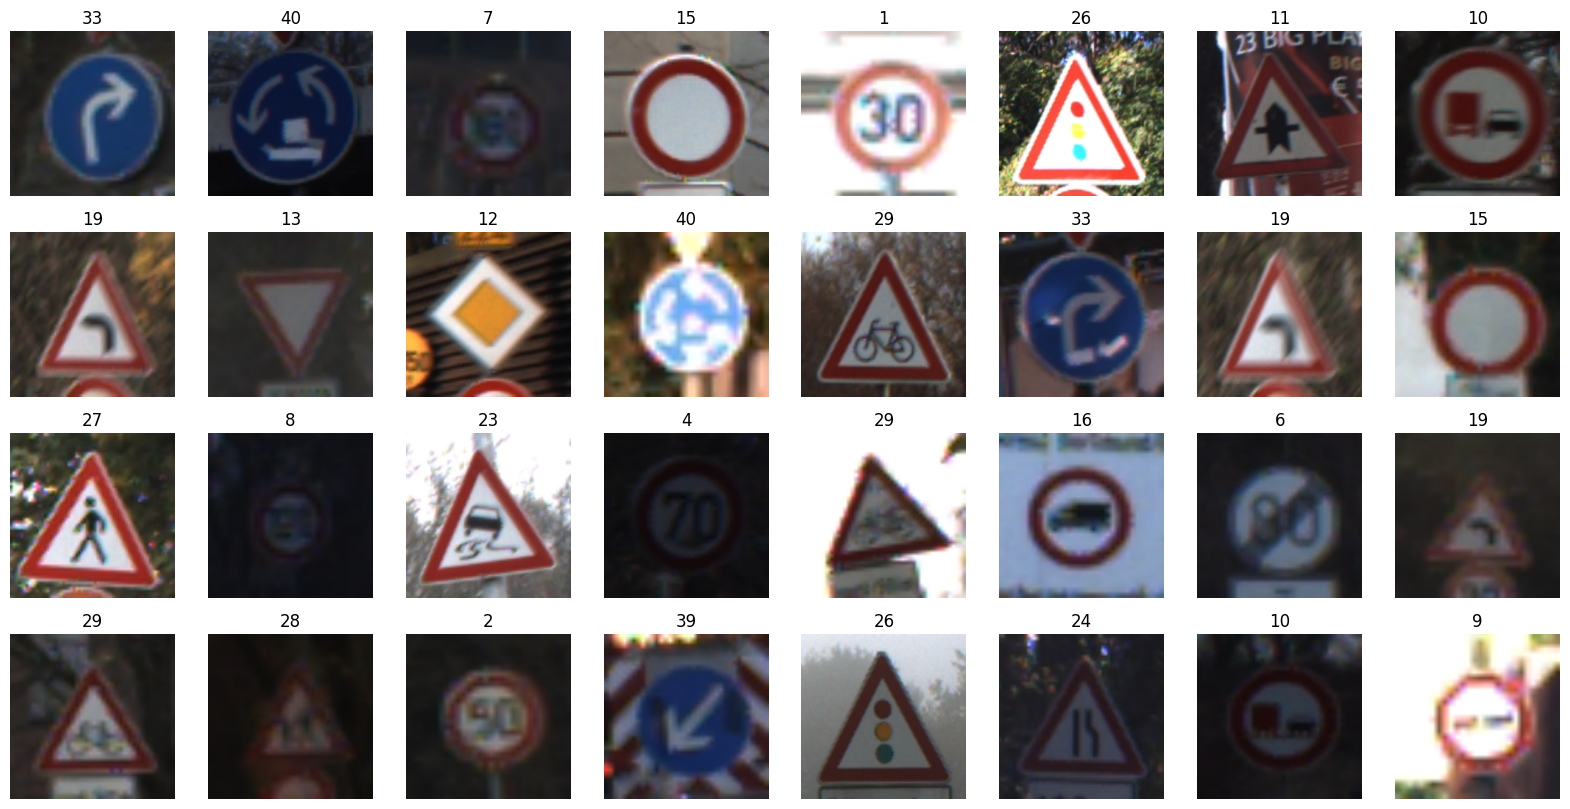

In [9]:
class_labels = train_dataset.class_names

num_rows = 4
num_cols = 8

plt.figure(figsize=(20, 10))

image_batch, label_batch = next(iter(train_dataset))
for i in range(num_rows * num_cols):
  plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  truth_idx = label_batch[i].numpy()
  plt.title(class_labels[truth_idx])
  plt.axis('off')

- Create a test dataset.

In [10]:
df = pd.read_csv(DatasetConfig.DATA_TEST_GT)
cols = [6]
df = df[df.columns[cols]]
ground_truth_ids = df['ClassId'].values.tolist()
print("Total number of test labels:", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of test labels: 12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


- Map ground truth ids to ids in train/valid.

In [11]:
#Convert train ids into integers.
class_names_int = list(map(int, train_dataset.class_names))

#Dictionary mapping ground truth ids to class name ids.
ground_2_class = dict(zip(class_names_int, range(0, DatasetConfig.NUM_CLASSES)))

ground_2_class.items()

dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [12]:
#Convert test class ids to map the ids in the train/valid.
class_ids = []
for idx in range(len(ground_truth_ids)):
  class_ids.append(ground_2_class[ground_truth_ids[idx]])

print("Original class ids: ", ground_truth_ids[0:10])
print("New required mapping: ", class_ids[0:10])
print("\nTrain/valid class names: \n", train_dataset.class_names)

Original class ids:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New required mapping:  [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/valid class names: 
 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


- Create file paths to test images.

In [13]:
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + '/*.png'))

print(len(image_paths))

for i in range(5):
  print(image_paths[i])

12630
./dataset_traffic_signs_40_samples_per_class/Test/00000.png
./dataset_traffic_signs_40_samples_per_class/Test/00001.png
./dataset_traffic_signs_40_samples_per_class/Test/00002.png
./dataset_traffic_signs_40_samples_per_class/Test/00003.png
./dataset_traffic_signs_40_samples_per_class/Test/00004.png


- Combine test images and labels to create the test dataset.

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, class_ids))

- Load and preprocess the test images.

In [15]:
def preprocess_image(image):
  #Decode and preprocess image.
  decoded_image = tf.image.decode_png(image, channels=3)
  img = tf.image.resize(decoded_image, (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT))

  return img


def load_and_preprocess(path):
  #Reag image into memor as byte string.
  image = tf.io.read_file(path)

  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess(path), label

In [16]:
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)

#Set the batchsize
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

- Display images from the test dataset

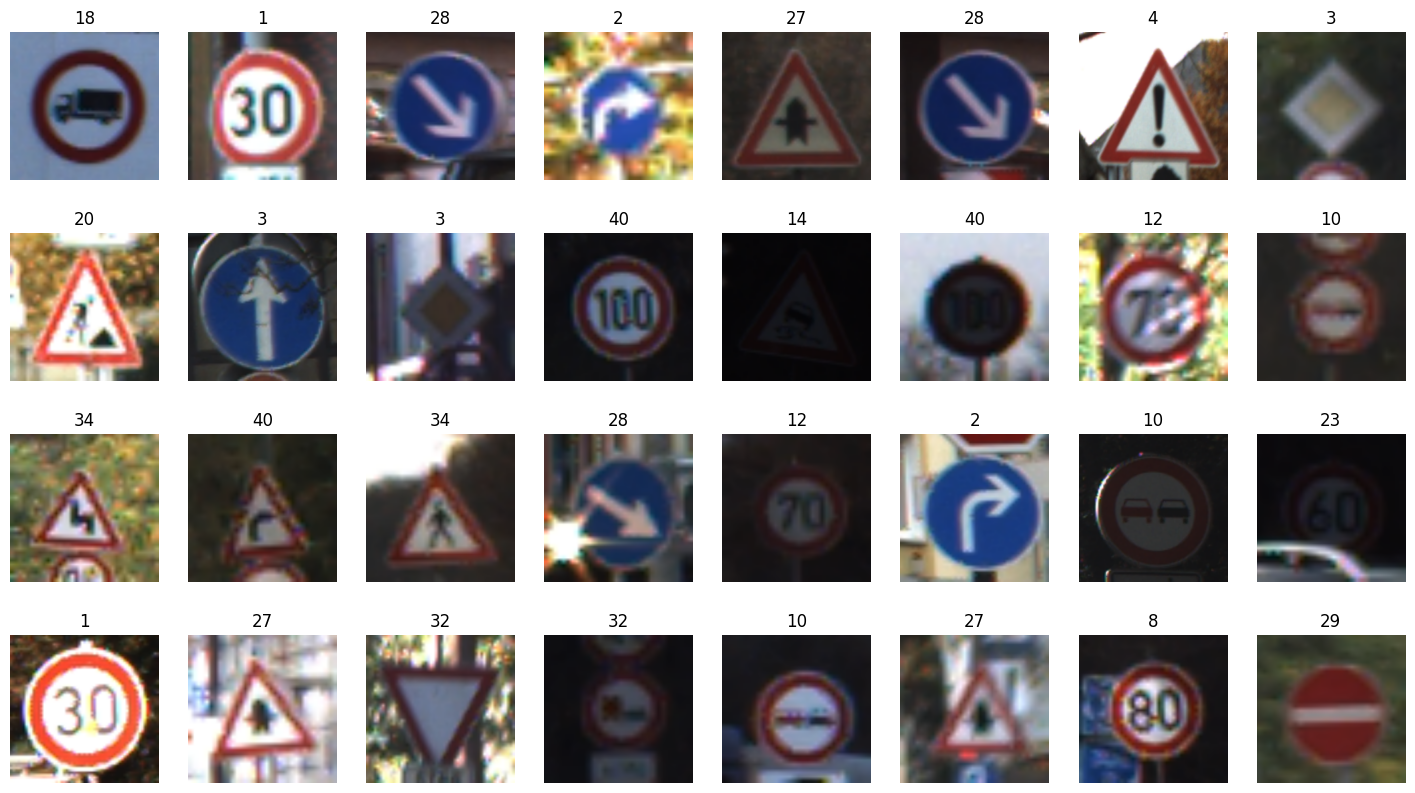

In [17]:
plt.figure(figsize=(18, 10))

num_rows = 4
num_cols = 8

for image_batch, label_batch in test_dataset.take(1):
  for i in range(num_rows *  num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    truth_idx = label_batch[i].numpy()
    plt.title(class_ids[truth_idx])
    plt.axis('off')

### Modeling VGG-16 for fine-tuning.

In [18]:
model_vgg = tf.keras.applications.vgg16.VGG16(include_top=True,
                                              weights='imagenet',
                                              input_tensor=None,
                                              input_shape=None,
                                              pooling=None,
                                              classes=1000,
                                              classifier_activation='softmax'
                                              )

553467096/553467096 [==============================] - 2s 0us/step


- Load the convolutional base

In [19]:
input_shape = (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT, DatasetConfig.NUM_CHANNELS)

print("Loading VGG model with the ImageNet weights...", end="")

vgg_conv_base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape=input_shape,
                                                  weights='imagenet')

print(vgg_conv_base.summary())

Loading VGG model with the ImageNet weights...Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
         

- Freeze the initial layers in the convolutional base.

In [20]:
#Set all layers to be trainable
vgg_conv_base.trainable = True

#Specify the number of layers to fine tune at the end of convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg_conv_base.layers)

#Freeze the initial layers in the convolutional base.
for model_layer in vgg_conv_base.layers[:num_layers - num_layers_fine_tune]:
  print(f"FREEZING LAYER: {model_layer}")
  model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")

print(vgg_conv_base.summary())


FREEZING LAYER: <keras.src.engine.input_layer.InputLayer object at 0x7b60e017c8e0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b60e017c820>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b60e01c52d0>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b6199a1ef80>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b610cf5a290>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b6199a1fca0>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b60e034f8e0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b60e04cfd30>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b60e034c130>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b610c219ea0>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b60e034d5d0>


Configured to 

- Add the classifier to complete the model.

In [21]:
inputs = tf.keras.Input(shape=input_shape)

preprocess_input = tf.keras.applications.vgg16.preprocess_input(inputs)

model = vgg_conv_base(preprocess_input)

#Flatten the output from the convolutional base.
model = layers.Flatten()(model)

#Add the classifier.
model = layers.Dense(128, activation='relu')(model)
model = layers.Dropout(TrainingConfig.DROPOUT)(model)

#Output layer.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(model)

#The final model.
vgg_fine_tuned = keras.Model(inputs, outputs)

print(vgg_fine_tuned.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               321139

### Compile and Train the model.

In [22]:
vgg_fine_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'],
                       )

In [23]:
training_results = vgg_fine_tuned.fit(train_dataset,
                                      epochs=TrainingConfig.EPOCHS,
                                      validation_data=valid_dataset,
                                      )

Epoch 1/101


I0000 00:00:1708509087.197748      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - 36s 507ms/step - loss: 4.6764 - accuracy: 0.0233 - val_loss: 3.7421 - val_accuracy: 0.0368
Epoch 2/101
38/38 [==============================] - 9s 242ms/step - loss: 3.7442 - accuracy: 0.0341 - val_loss: 3.7283 - val_accuracy: 0.0504
Epoch 3/101
38/38 [==============================] - 9s 242ms/step - loss: 3.6943 - accuracy: 0.0415 - val_loss: 3.5891 - val_accuracy: 0.0620
Epoch 4/101
38/38 [==============================] - 9s 244ms/step - loss: 3.6199 - accuracy: 0.0706 - val_loss: 3.5888 - val_accuracy: 0.0601
Epoch 5/101
38/38 [==============================] - 9s 245ms/step - loss: 3.4703 - accuracy: 0.0955 - val_loss: 3.3186 - val_accuracy: 0.1298
Epoch 6/101
38/38 [==============================] - 9s 248ms/step - loss: 3.2266 - accuracy: 0.1445 - val_loss: 3.1304 - val_accuracy: 0.2035
Epoch 7/101
38/38 [==============================] - 10s 250ms/step - loss: 2.8182 - accuracy: 0.2475 - val_loss: 2.3248 - val_accuracy: 0.4070
Epoch 8/1

In [30]:
def plot_results(metrics, title=None, ylim=None, ylabel=None, metric_name=None, colors=None):
    fig, ax = plt.subplots(figsize=(15, 5))
    
    if not (isinstance(metric_name, list) or (isinstance(metric_name, tuple))):
        metrics = [metrics, ]
        metric_name = [metric_name, ]
        
    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=colors[idx])
        
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    plt.title(title)
    
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    plt.grid()
    plt.legend(metric_name)
    plt.show()
    plt.close()

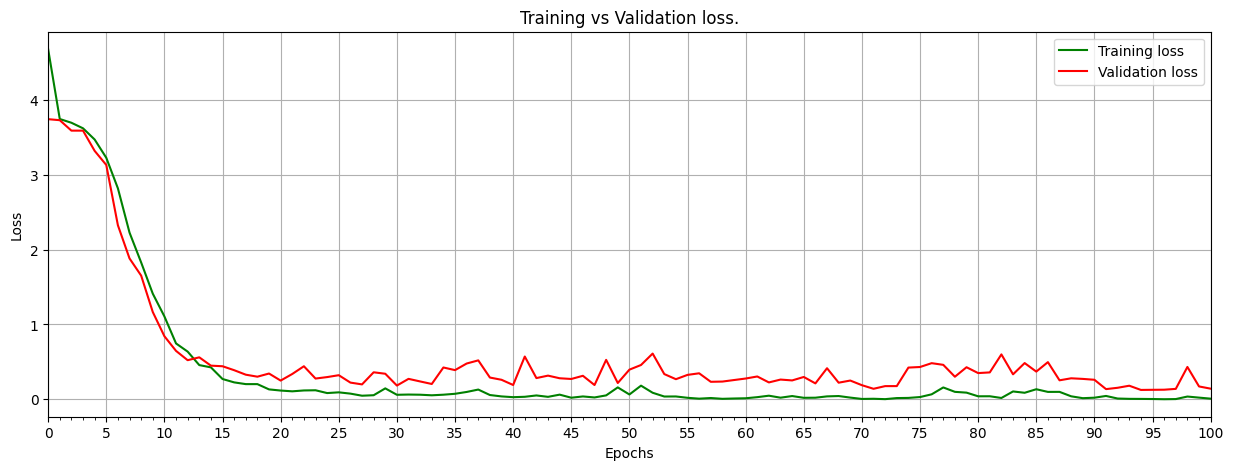

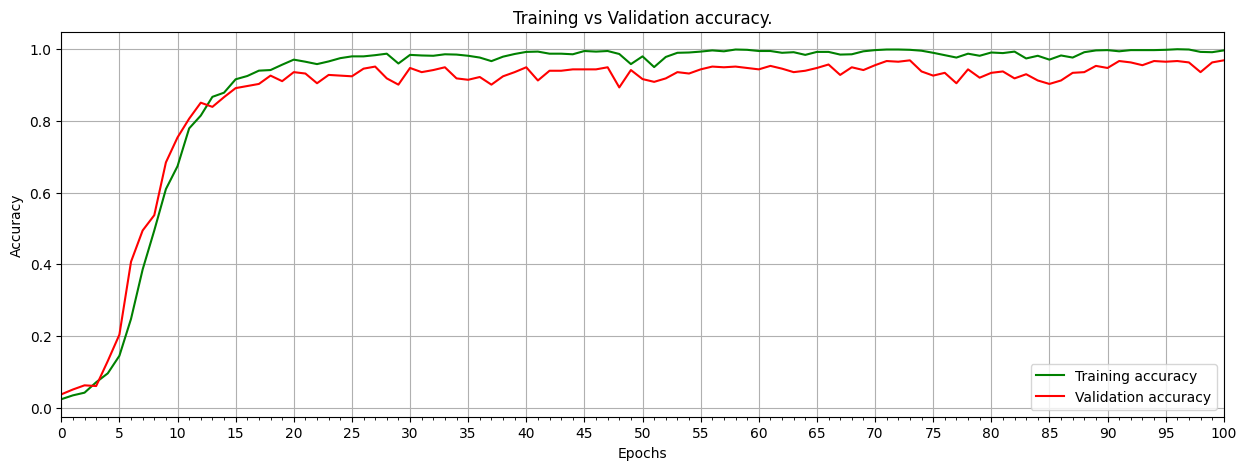

In [31]:
train_acc = training_results.history['accuracy']
train_loss = training_results.history['loss']
val_acc = training_results.history['val_accuracy']
val_loss = training_results.history['val_loss']

plot_results(metrics=[train_loss, val_loss],
             ylabel='Loss', title='Training vs Validation loss.',
             metric_name=['Training loss', 'Validation loss'],
             colors=['g', 'r'])

plot_results(metrics=[train_acc, val_acc],
             ylabel='Accuracy', title='Training vs Validation accuracy.',
             metric_name=['Training accuracy', 'Validation accuracy'],
             colors=['g', 'r'])

### Model Evaluation
 1. Validation dataset.

In [34]:
print(f"Model validation accuracy: {vgg_fine_tuned.evaluate(valid_dataset)[1] * 100:.3f}")

17/17 [==============================] - 2s 114ms/step - loss: 0.1426 - accuracy: 0.9690
Model validation accuracy: 96.899


2. Test dataset.

In [36]:
print(f"Model test accuracy: {vgg_fine_tuned.evaluate(test_dataset)[1] * 100.:.3f}")

395/395 [==============================] - 48s 121ms/step - loss: 0.2567 - accuracy: 0.9523
Model test accuracy: 95.226


3. Displaying sample image predictions.

In [59]:
def display_predictions(dataset, model, class_names):
    plt.figure(figsize=(20, 20))
    
    num_rows = 8
    num_cols = 8
    jdx = 0
    
    
    #Evaluate 2 batches.
    for image_batch, label_batch in dataset.take(2):
        print(image_batch.shape)
        
        #Make predictions for the current batch.
        predictions = model.predict(image_batch)
        
        #Loop over all images in the current batch.
        for idx in range(len(label_batch)):
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = label_batch[idx].numpy()
            
            if pred_idx == truth_idx:
                color = 'g'
            else:
                color = 'r'
                
            jdx += 1
            if jdx > num_rows * num_cols:
                #Break the loop if the maximum number of images have been plotted.
                break
                
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + ':' + str(class_names[pred_idx])
            
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis('off')
            plt.imshow(image_batch[idx].numpy().astype('uint8'))
            
    return

(32, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
(32, 224, 224, 3)
1/1 [==============================] - 0s 29ms/step


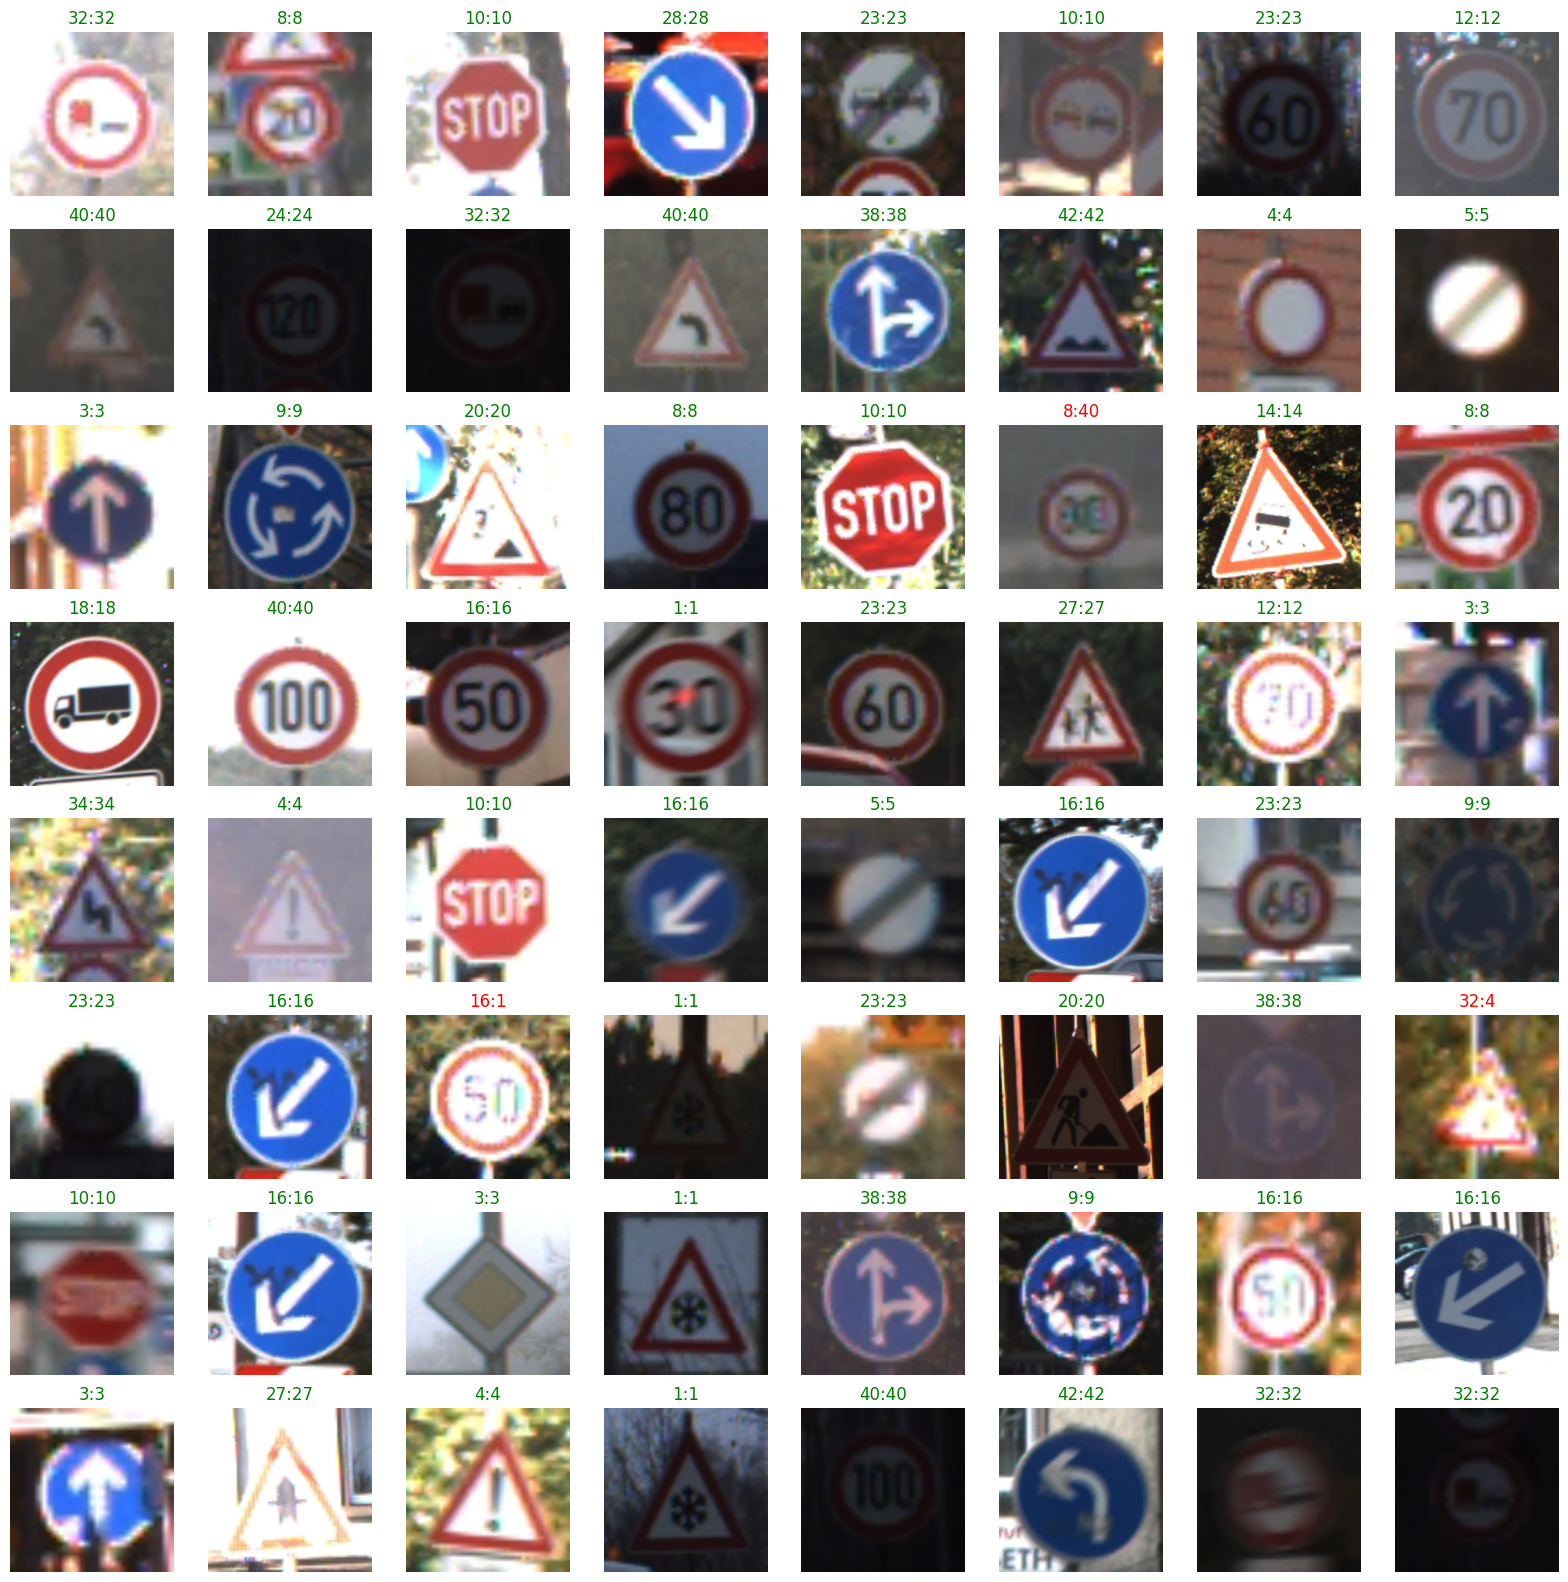

In [60]:
display_predictions(valid_dataset, vgg_fine_tuned, class_ids)

(32, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
(32, 224, 224, 3)
1/1 [==============================] - 0s 29ms/step


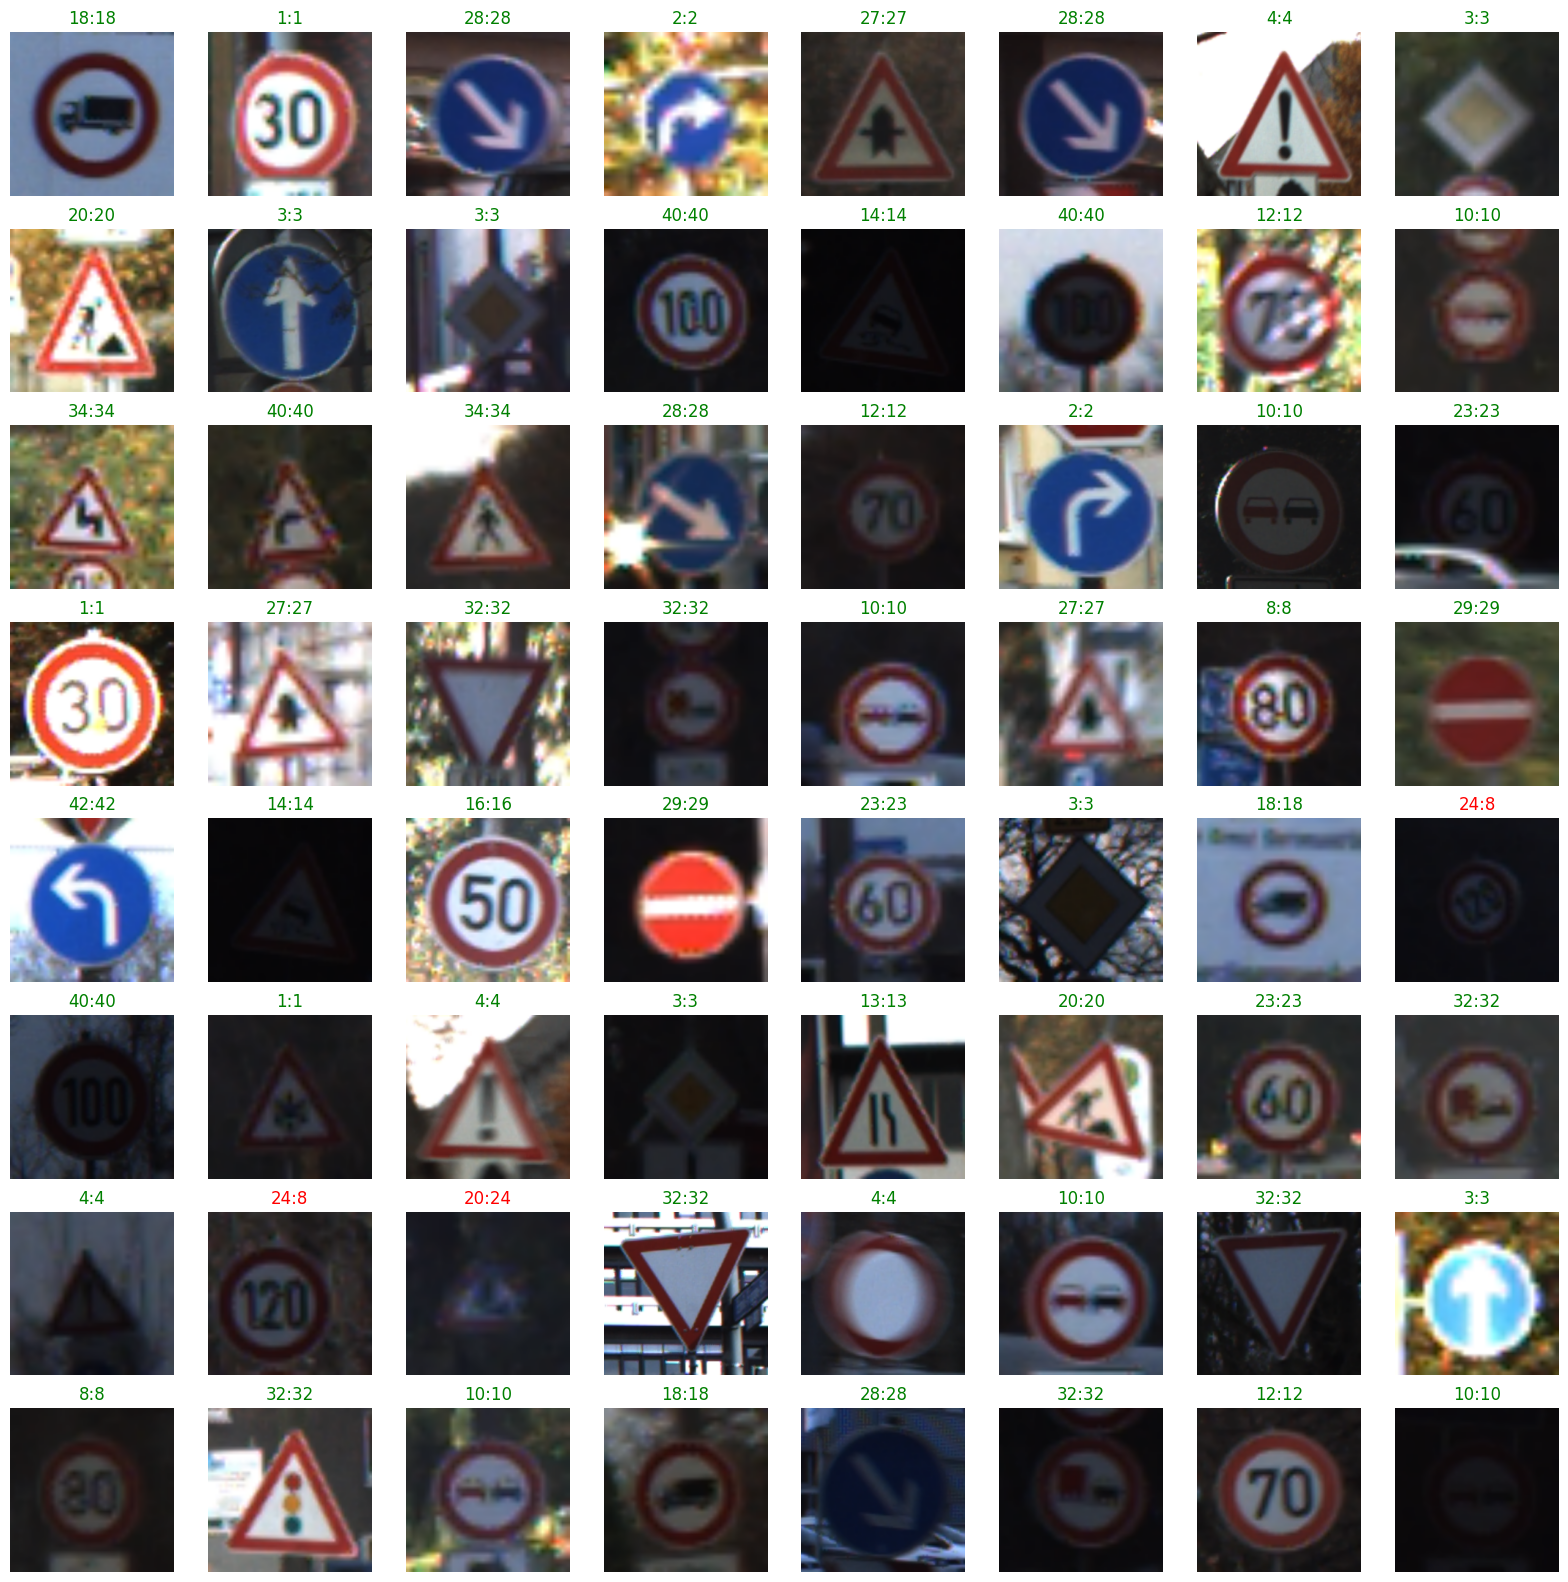

In [61]:
display_predictions(test_dataset, vgg_fine_tuned, class_ids)